In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
print(os.listdir('../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/no'))

['34 no.jpg', 'N20.JPG', 'N1.JPG', '49 no.jpg', 'N15.jpg', 'No18.jpg', '31 no.jpg', 'no 6.jpg', '3 no.jpg', 'no 5.jpeg', 'no 1.jpg', '26 no.jpg', 'N26.JPG', 'N5.jpg', '6 no.jpg', 'No21.jpg', '17 no.jpg', 'No22.jpg', '29 no.jpg', '46 no.jpg', '32 no.jpg', '42 no.jpg', 'no 90.jpg', 'no 94.jpg', 'No19.jpg', '47 no.jpg', 'N22.JPG', 'No12.jpg', '15 no.jpg', '20 no.jpg', 'No13.jpg', '11 no.jpg', 'N11.jpg', 'No17.jpg', 'no 98.jpg', '18 no.jpg', 'N19.JPG', '25 no.jpg', '24 no.jpg', 'no 91.jpeg', '45 no.jpg', '22 no.jpg', 'No16.jpg', '44no.jpg', '4 no.jpg', '36 no.jpg', '8 no.jpg', '48 no.jpeg', 'No20.jpg', 'no 2.jpg', 'no 10.jpg', '7 no.jpg', '10 no.jpg', 'N17.jpg', '14 no.jpg', 'no 8.jpg', '38 no.jpg', '40 no.jpg', 'no 9.png', 'N3.jpg', 'no 89.jpg', '19 no.jpg', '12 no.jpg', 'N2.JPG', 'No11.jpg', 'no 92.jpg', 'No14.jpg', '39 no.jpg', 'no 7.jpeg', '27 no.jpg', '5 no.jpg', 'no 95.jpg', 'no.jpg', 'no 3.jpg', 'No15.jpg', 'no 923.jpg', '28 no.jpg', 'no 100.jpg', '23 no.jpg', '13 no.jpg', '37 no.jp

In [4]:
print(os.listdir('../input/brain-mri-images-for-brain-tumor-detection/no'))

['34 no.jpg', 'N20.JPG', 'N1.JPG', '49 no.jpg', 'N15.jpg', 'No18.jpg', '31 no.jpg', 'no 6.jpg', '3 no.jpg', 'no 5.jpeg', 'no 1.jpg', '26 no.jpg', 'N26.JPG', 'N5.jpg', '6 no.jpg', 'No21.jpg', '17 no.jpg', 'No22.jpg', '29 no.jpg', '46 no.jpg', '32 no.jpg', '42 no.jpg', 'no 90.jpg', 'no 94.jpg', 'No19.jpg', '47 no.jpg', 'N22.JPG', 'No12.jpg', '15 no.jpg', '20 no.jpg', 'No13.jpg', '11 no.jpg', 'N11.jpg', 'No17.jpg', 'no 98.jpg', '18 no.jpg', 'N19.JPG', '25 no.jpg', '24 no.jpg', 'no 91.jpeg', '45 no.jpg', '22 no.jpg', 'No16.jpg', '44no.jpg', '4 no.jpg', '36 no.jpg', '8 no.jpg', '48 no.jpeg', 'No20.jpg', 'no 2.jpg', 'no 10.jpg', '7 no.jpg', '10 no.jpg', 'N17.jpg', '14 no.jpg', 'no 8.jpg', '38 no.jpg', '40 no.jpg', 'no 9.png', 'N3.jpg', 'no 89.jpg', '19 no.jpg', '12 no.jpg', 'N2.JPG', 'No11.jpg', 'no 92.jpg', 'No14.jpg', '39 no.jpg', 'no 7.jpeg', '27 no.jpg', '5 no.jpg', 'no 95.jpg', 'no.jpg', 'no 3.jpg', 'No15.jpg', 'no 923.jpg', '28 no.jpg', 'no 100.jpg', '23 no.jpg', '13 no.jpg', '37 no.jp

In [5]:
DATASET_PATH = "../input/brain-mri-images-for-brain-tumor-detection"


In [6]:
!apt-get install tree
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.8.0-1).
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
.
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

9 directories


In [7]:
import shutil
IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [8]:
from tqdm import tqdm
import cv2
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  4.70it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 47.80it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 18.91it/s]

50 images loaded from VAL/ directory.


In [9]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
#     Reference: https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)


In [12]:
import imutils
img = cv2.imread('../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

In [11]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=da98700abf26cc10efa119fe077dfa40d7077aa509e04e9cfbcaee95a81b8a8e
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [13]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [14]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [15]:

# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [16]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [17]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [27]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='binary',
    seed=24
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='binary',
    seed=24
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [19]:
base_model = VGG16(
    weights="imagenet",
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

2022-09-21 13:46:51.745569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 13:46:51.855005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 13:46:51.856143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 13:46:51.858602: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [20]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [45]:
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=24,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=5,
    callbacks=[es]
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
24/24 [==============================] - 3s 126ms/step - loss: 0.6108 - accuracy: 0.9135 - val_loss: 1.1997 - val_accuracy: 0.8750
Epoch 2/30
24/24 [==============================] - 3s 128ms/step - loss: 0.7316 - accuracy: 0.9189 - val_loss: 1.2790 - val_accuracy: 0.8500
Epoch 3/30
24/24 [==============================] - 3s 132ms/step - loss: 0.6451 - accuracy: 0.9297 - val_loss: 0.7910 - val_accuracy: 0.8750
Epoch 4/30
24/24 [==============================] - 3s 124ms/step - loss: 0.7838 - accuracy: 0.9243 - val_loss: 0.5675 - val_accuracy: 0.9250
Epoch 5/30
24/24 [==============================] - 3s 144ms/step - loss: 0.6777 - accuracy: 0.9135 - val_loss: 1.2926 - val_accuracy: 0.9000
Epoch 6/30
24/24 [==============================] - 3s 124ms/step - loss: 0.8672 - accuracy: 0.9027 - val_loss: 1.1288 - val_accuracy: 0.9000
Epoch 7/30
24/24 [==============================] - 3s 123ms/step - loss: 1.0518 - accuracy: 0.9189 - val_loss: 1.2654 - val_accuracy: 0.8250
Epoch 

In [46]:
len(os.listdir('VAL_CROP/NO'))

19

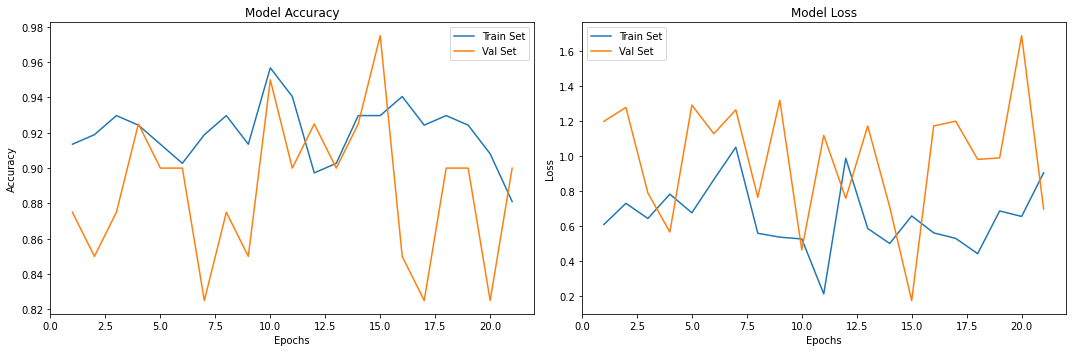

In [47]:
import matplotlib.pyplot as plt

# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Val Accuracy = 0.84


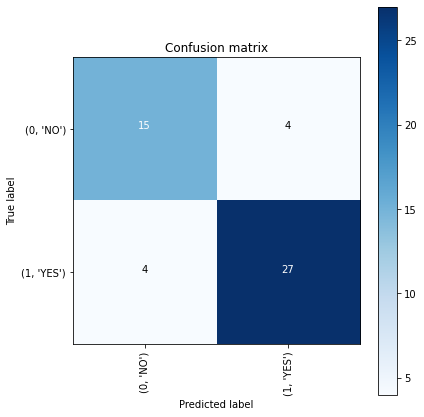

In [49]:
# validate on val set
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.70


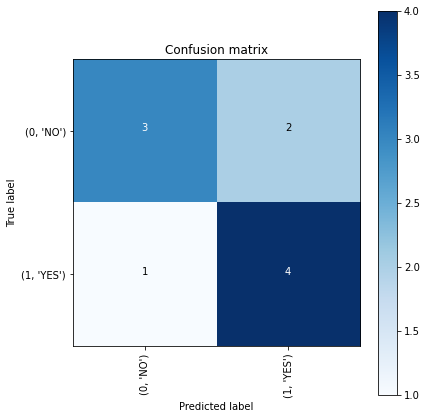

In [50]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)